Initializing NUTS using jitter+adapt_diag...


Nr elevi care au promovat: 250
Nr elevi care nu au promovat: 250
Observam ca datele sunt perfect balansate.



Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 293 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
C:\Users\gabri\AppData\Local\Temp\ipykernel_9344\1934206159.py:62: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:, 0], X[:, 1], c=[f'C{int(i)}' for i in y],


Intercept (alpha): -0.3043
Coeficient Ore_Studiu (beta[0]): 2.4740
Coeficient Ore_Somn (beta[1]): 2.9251

Ecuatia frontierei medii: Ore_Somn = 9.96 + (-0.85) * Ore_Studiu
6.65 6.32
Se observa ca datele sunt foarte bine separate (nu exista suprapunere intre clase pe axa orelor de somn).

Orele de somn au o influenta mai mare asupra succesului: |2.93| > |2.47|



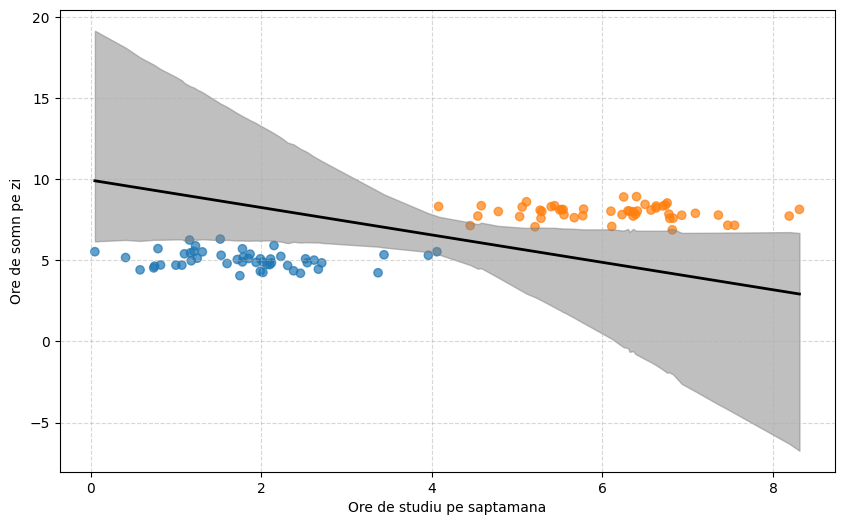

In [5]:
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

df = pd.read_csv('date_promovare_examen.csv')

# Punctul a
counts = df['Promovare'].value_counts()
print(f"Nr elevi care au promovat: {counts[1]}")
print(f"Nr elevi care nu au promovat: {counts[0]}")
print("Observam ca datele sunt perfect balansate.")
print()

X = df[['Ore_Studiu', 'Ore_Somn']].values[::5]
y = df['Promovare'].values[::5]

X_mean = X.mean(axis=0)
X_centered = X - X_mean

with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=2, shape=2)
    
    mu = alpha + pm.math.dot(X_centered, beta)
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    bd = pm.Deterministic('bd', -alpha/beta[1] - (beta[0]/beta[1]) * X_centered[:, 0])
    yl = pm.Bernoulli('yl', p=theta, observed=y)
    
    idata = pm.sample(1000, target_accept=0.9, return_inferencedata=True, random_seed=1)

post_alpha = idata.posterior['alpha'].mean().values
post_beta = idata.posterior['beta'].mean(dim=['chain', 'draw']).values

print(f"Intercept (alpha): {post_alpha:.4f}")
print(f"Coeficient Ore_Studiu (beta[0]): {post_beta[0]:.4f}")
print(f"Coeficient Ore_Somn (beta[1]): {post_beta[1]:.4f}")

# Punctul b
slope_orig = -post_beta[0] / post_beta[1]
intercept_orig = X_mean[1] - (post_alpha / post_beta[1]) - (slope_orig * X_mean[0])
print(f"\nEcuatia frontierei medii: Ore_Somn = {intercept_orig:.2f} + ({slope_orig:.2f}) * Ore_Studiu")

min_1_somn = df[df['Promovare'] == 1]['Ore_Somn'].min()
max_0_somn = df[df['Promovare'] == 0]['Ore_Somn'].max()
print(min_1_somn, max_0_somn)

print("Se observa ca datele sunt foarte bine separate (nu exista suprapunere intre clase pe axa orelor de somn).")
print()

# Punctul c
print(f"Orele de somn au o influenta mai mare asupra succesului: |{abs(post_beta[1]):.2f}| > |{abs(post_beta[0]):.2f}|")
print()

# Grafic
plt.figure(figsize=(10, 6))

idx = np.argsort(X_centered[:, 0])
bd_samples = idata.posterior['bd'].stack(samples=("chain", "draw")).values

plt.scatter(X[:, 0], X[:, 1], c=[f'C{int(i)}' for i in y], 
            cmap='viridis', alpha=0.7, label='Studenti (Promovat/Nepromovat)')

x_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
y_boundary = intercept_orig + slope_orig * x_range
plt.plot(x_range, y_boundary, color='black', linewidth=2, label='Granita de decizie (medie)')

az.plot_hdi(X[:, 0], idata.posterior['bd'] + X_mean[1], color='gray', 
            smooth=False, fill_kwargs={"label": "Incertitudine frontiera (HDI 94%)"})

plt.xlabel('Ore de studiu pe saptamana')
plt.ylabel('Ore de somn pe zi')
plt.grid(True, linestyle='--', alpha=0.5)
